In [31]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

In [2]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Greek.txt', 'data/names/Portuguese.txt', 'data/names/Dutch.txt', 'data/names/Irish.txt', 'data/names/German.txt', 'data/names/Spanish.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/Polish.txt', 'data/names/French.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Russian.txt', 'data/names/Czech.txt']


In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(all_letters, n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;' 57


In [5]:
# Turn a unicode string into plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [42]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [40]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([5, 1, 57])


In [23]:
# Creating the model. Muawhahaha >:>

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        #print(combined.size())
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [16]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, hidden)
print(output)

torch.Size([1, 185])
Variable containing:

Columns 0 to 9 
-2.8121 -2.8074 -2.9316 -2.8014 -2.8735 -2.9062 -3.0254 -2.9097 -2.7714 -2.8787

Columns 10 to 17 
-2.8026 -2.9991 -2.9307 -2.9723 -2.9809 -2.8203 -2.8800 -2.9755
[torch.FloatTensor of size 1x18]



In [17]:
input = Variable(lineToTensor('Albert'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input[0], hidden)
print(output)

torch.Size([1, 185])
Variable containing:

Columns 0 to 9 
-2.8186 -2.8744 -2.9571 -2.8250 -2.9059 -2.9135 -2.9556 -2.8431 -2.8322 -2.8871

Columns 10 to 17 
-2.8221 -2.9411 -2.9277 -2.9456 -2.9164 -2.8348 -2.8934 -2.9551
[torch.FloatTensor of size 1x18]



In [18]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 0)


In [39]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ name =', line)

category = Italian / name = Ratti
category = Irish / name = O'Rourke
category = French / name = Sault
category = German / name = Gunther
category = Arabic / name = Saliba
category = Scottish / name = Macdonald
category = German / name = Wornhor
category = German / name = Aleshire
category = Portuguese / name = Rosario
category = Russian / name = Jernovoy


In [43]:
# Loss and training
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = loss_fn(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    optimizer.step()

    return output, loss.data[0]

In [44]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 4s) 2.3155 Otaka / Japanese ✓
10000 10% (0m 8s) 1.6105 Jalchevsky / Polish ✗ (Russian)
15000 15% (0m 12s) 1.7246 Phung / Chinese ✗ (Vietnamese)
20000 20% (0m 17s) 0.7285 Zang / Chinese ✓
25000 25% (0m 22s) 0.8790 Shuai / Chinese ✓
30000 30% (0m 26s) 2.9045 Pinsmail / Arabic ✗ (English)
35000 35% (0m 30s) 0.6474 Jue / Chinese ✓
40000 40% (0m 35s) 0.8034 Castro / Portuguese ✓
45000 45% (0m 39s) 0.6974 Rodriquez / Spanish ✓
50000 50% (0m 43s) 1.0324 Ngo / Korean ✗ (Vietnamese)
55000 55% (0m 47s) 1.1201 Baik / Korean ✓
60000 60% (0m 51s) 0.2062 Mai / Chinese ✓
65000 65% (0m 55s) 0.9457 Ho / Vietnamese ✗ (Korean)
70000 70% (0m 59s) 1.8376 Basurto / Portuguese ✗ (Spanish)
75000 75% (1m 3s) 0.1783 Stamatelos / Greek ✓
80000 80% (1m 7s) 0.9930 Herrera / Spanish ✓
85000 85% (1m 10s) 3.0753 Chlebek / Dutch ✗ (Polish)
90000 90% (1m 14s) 2.5980 Maria / Arabic ✗ (Portuguese)
95000 95% (1m 18s) 0.8743 Munakata / Japanese ✓
100000 100% (1m 22s) 1.0862 Sneijder / Dutch ✓


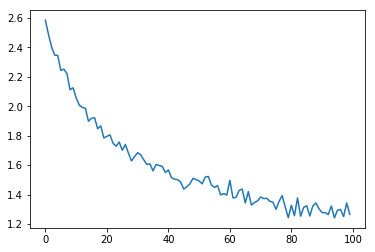

In [45]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

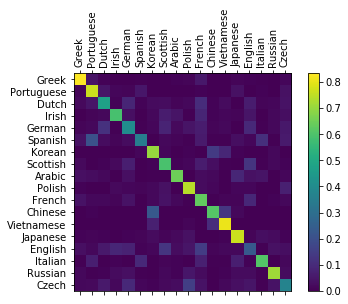

In [46]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
# Deeper model and using LSTM

HIDDEN_DIM = 128

class NameClassifierLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_dim, output_size):
        super(NameClassifierLSTM, self).__init__()
        self.hidden_size = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, inputs):
        out = None
        hidden = self.init_hidden()
        #for i in range(inputs.size()[0]):
         #   input = inputs[i].view(1, 1, 57)
            #print(input.size())
            out, hidden = self.lstm(input[i].view(len(input), 1, -1), hidden)
        out = self.fc1(out.view(1, -1))
        out = self.softmax(out)
        #print(out.size())
        return out
    
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (Variable(torch.zeros(1, 1, self.hidden_size)),
                Variable(torch.zeros(1, 1, self.hidden_size)))

classifier = NameClassifierLSTM(n_letters, HIDDEN_DIM, n_categories)

In [108]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(classifier.parameters(), lr = 1e-5)

In [110]:
# Training

epochs = 100000
# Keep track of losses for plotting
current_loss = 0
all_losses = []
for epoch in range(epochs):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    
    output = classifier(line_tensor)
    
    loss = loss_fn(output, category_tensor)
    loss.backward()
    current_loss += loss.data[0]
    
    optimizer.step()
    
    # Print iter number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / epochs * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

0 0% (70m 35s) 5.3424 Maly / Scottish ✗ (Polish)
5000 5% (70m 51s) 1.7352 Porra / Italian ✗ (Spanish)
10000 10% (71m 8s) 0.0664 Yamhata / Japanese ✓
15000 15% (71m 23s) 0.0123 Gwang  / Korean ✓
20000 20% (71m 39s) 2.1962 Diaz / Portuguese ✗ (Spanish)
25000 25% (71m 55s) 0.2231 Maessen / Dutch ✓
30000 30% (72m 10s) 0.0187 Mansour / Arabic ✓
35000 35% (72m 26s) 1.7349 Henderson / English ✗ (Scottish)
40000 40% (72m 43s) 0.1069 Mach / Vietnamese ✓
45000 45% (72m 59s) 0.2272 Yu / Korean ✓
50000 50% (73m 15s) 1.9986 Ko / Vietnamese ✗ (Korean)
55000 55% (73m 31s) 0.1827 Gouveia / Portuguese ✓
60000 60% (73m 46s) 0.0074 Thi / Vietnamese ✓
65000 65% (74m 2s) 1.6859 Mitchell / Irish ✗ (Scottish)
70000 70% (74m 18s) 1.2116 Johnstone / Scottish ✓
75000 75% (74m 33s) 0.1903 Esteves / Portuguese ✓
80000 80% (74m 50s) 0.6770 Tayama / Japanese ✓
85000 85% (75m 6s) 0.7636 Cheng / Chinese ✓
90000 90% (75m 22s) 3.0800 Kaiser / German ✗ (Czech)
95000 95% (75m 38s) 1.5397 Sabbag / Arabic ✓


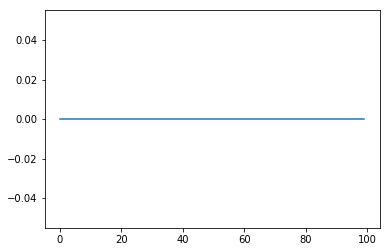

In [111]:
plt.figure()
plt.plot(all_losses)
plt.show()

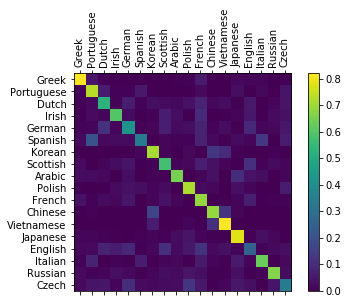

In [112]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()